In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import scipy
from scipy.optimize import minimize

In [29]:
df_cov = pd.read_csv(r'Data/df_dow_cov.csv', index_col = 0)
df_return= pd.read_csv(r'Data\df_dow_price.csv', index_col = 0)
df_SP500_returns = pd.read_csv('Data\dow_raw_data.csv', index_col = 0)

In [30]:
df_cov.iloc[0:5, 0:5]

,AAPL,AMGN,AMZN,AXP,BA
Tickers,,,,,
AAPL,0.000398,0.000129,0.000267,0.000217,0.000267
AMGN,0.000129,0.000259,0.000095,0.000122,0.000105
AMZN,0.000267,0.000095,0.000498,0.000169,0.000205
AXP,0.000217,0.000122,0.000169,0.000567,0.000487
BA,0.000267,0.000105,0.000205,0.000487,0.001033


Defining all the equation that we need to consider

In [31]:
# Define the objective function to minimize (portfolio variance)
# Based on an equation
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

#get the value of the covariance matrix
cov_matrix = df_cov.values

# Define the Sharpe ratio
def sharpe_r(weights, expected_returns, daily_rf_rate):
    # Calculate the portfolio's expected return
    port_e_r = np.sum(weights * expected_returns)
    # Calculate the portfolio's variance
    port_variance = portfolio_variance(weights, cov_matrix)
    # Calculate the portfolio's standard deviation (risk)
    port_std_dev = np.sqrt(port_variance)
    # Calculate the Sharpe ratio
    return (port_e_r - daily_rf_rate) / port_std_dev

# Defined the expected return 
def port_er(x):
    return sum(x * df_return['Return'])

In [32]:
import yfinance as yf

# Get the 3-month Treasury bill rate
t_bill = yf.Ticker("^IRX")
t_bill_rate = t_bill.history(period="1d")['Close'].iloc[-1]

# Convert to annual rate (assuming t_bill_rate is in percentage)
annual_rf_rate = (t_bill_rate / 100) * 4

# Convert to daily risk-free rate
daily_rf_rate = (1 + annual_rf_rate) ** (1 / 252) - 1

print(f"3-Month Treasury Bill Rate: {t_bill_rate:.2f}%")
print(f"Daily Risk-Free Rate: {daily_rf_rate:.8f}")

3-Month Treasury Bill Rate: 4.51%
Daily Risk-Free Rate: 0.00065769


In [33]:
# Download historical data for the index fund (e.g., S&P 500 ETF)
index_fund = yf.download('DIA', start='2019-08-30', end='2024-08-30')

# Calculate daily percentage change of the adjusted closing prices
index_fund = index_fund['Adj Close'].pct_change()

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Reset the index to turn the index into a column
df_index_fund.reset_index(inplace=True)

# Convert 'Date' column to datetime format
df_index_fund['Date'] = pd.to_datetime(df_index_fund['Date'])

# Set 'Date' column as the index
df_index_fund.set_index('Date', inplace=True)

# Display the DataFrame
df_index_fund

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2019-08-30,NaN
2019-09-03,-0.010261
2019-09-04,-0.000758
2019-09-05,0.013440
2019-09-06,0.015863
...,...
2024-08-23,0.715508
2024-08-26,0.719216
2024-08-27,0.719924


The section finds the Global Variance Optimization, the lowest portfolio variance there is

In [34]:
### How to run a minimize optimization problem

# Initial guess for the weights (random weights that sum to 1)
# Create as many weights as there are tickers
np.random.seed(42)
initial_weights = np.array([1.00 / len(df_cov)] * len(df_cov))

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # all weights sum to 1

# Bounds: weights must be between 0 and 1
bounds = [(0, 1) for _ in range(len(initial_weights))]

# Minimize the portfolio variance
# args provide the second portion of the portfolio_variance function
result = minimize(
    portfolio_variance, #the equation that we want to minimize
    initial_weights, #the initial guess
    args=(cov_matrix,) #additional variables data
    , method='SLSQP' 
    , bounds=bounds, constraints=constraints
    , options={'disp': True} #to see the process
    )

# Optimal weights
weights = result.x


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00016582480274762073
            Iterations: 1
            Function evaluations: 31
            Gradient evaluations: 1


Cleaning up data

Weights: [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
Global Minimum Portfolio Variance:  0.0129
Portfolio Expected Return:  0.0004
Annualized Return: 0.1006
Annualized Risk: 0.2044
Sharpe Ratio:-0.022
           Return      Risk  Min_risk_weights
Tickers                                      
AAPL     0.001206  0.019944             0.033
AMGN     0.000488  0.016084             0.033
AMZN     0.000527  0.022303             0.033
AXP      0.000668  0.023798             0.033
BA      -0.000586  0.032121             0.033
CAT      0.000953  0.020350             0.033
CRM      0.000399  0.024837             0.033
CSCO     0.000183  0.017469             0.033
CVX      0.000356  0.022549             0.033
D

C:\Users\david\AppData\Local\Temp\ipykernel_15624\3662280919.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later


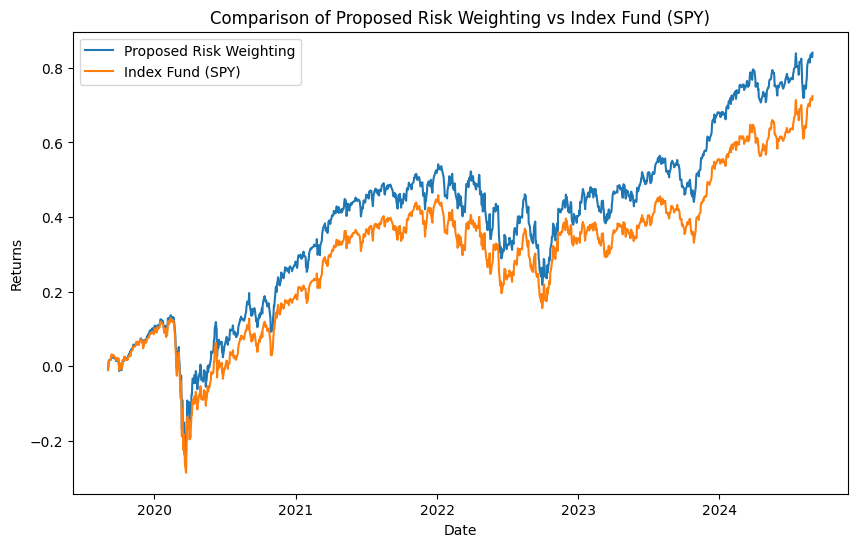

In [35]:
## Calculate the risk and return, then annualize it

# Calculate the minimum portfolio variance (risk)
minimum_portfolio_variance = np.sqrt(portfolio_variance(weights, cov_matrix))

# Calculate the expected return of the portfolio
minimum_port_e_r = sum(weights * df_return['Return'])

print("Weights:", weights)
print("Global Minimum Portfolio Variance: ", f'{minimum_portfolio_variance:.4f}')
print('Portfolio Expected Return: ', f'{minimum_port_e_r:.4f}')

# Annualize the return
min_risk_annualized_return = (1 + minimum_port_e_r) ** 252 - 1
print(f"Annualized Return: {min_risk_annualized_return:.4f}")

# Annualize the risk (standard deviation)
min_risk_annualized_risk = minimum_portfolio_variance * np.sqrt(252)
print(f"Annualized Risk: {min_risk_annualized_risk:.4f}")

#print sharpe return
print(f"Sharpe Ratio:{sharpe_r(weights, minimum_port_e_r, daily_rf_rate):.3f}")

## Create a column with the new weight

# Copy the df_return dataframe
df_temp = df_return.copy()

# Add the 'Min_risk_weights' column to df_temp with the calculated weights
df_temp['Min_risk_weights'] = weights

# Round the 'Min_risk_weights' column to 3 decimal places
df_temp['Min_risk_weights'] = df_temp['Min_risk_weights'].round(decimals=3)

# Filter the dataframe to include only rows where 'Min_risk_weights' is not zero
# Reset the index and make a copy of the filtered dataframe
df_min_risk_weight = df_temp[df_temp['Min_risk_weights'] != 0].reset_index().copy()

# Set the 'Tickers' column as the index of the dataframe
df_min_risk_weight.set_index('Tickers', inplace=True)

# Display the dataframe
print(df_min_risk_weight)

##graphing portion
# Create a DataFrame for the cumulative returns of the proposed risk weighting
df_plot = pd.DataFrame(
    (1 + df_SP500_returns[df_min_risk_weight.index.to_list()]  # Select returns for the dates in df_min_risk_weight
     .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later
     .pct_change()  # Calculate daily percentage change
     .dot(df_min_risk_weight.iloc[:, 2].values)  # Dot product with the risk weights
    ).cumprod() - 1  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Rename the columns to 'Returns' and set the index name to 'Date'
df_plot.columns = ['Returns']
df_plot.index.name = 'Date'

# Convert the index to datetime format
df_plot.index = pd.to_datetime(df_plot.index)

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)
)

# Plot both dataframes on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['Returns'], label='Proposed Risk Weighting')
plt.plot(df_index_fund.index, df_index_fund.iloc[:, 0], label='Index Fund (SPY)')

# Adding title and labels
plt.title('Comparison of Proposed Risk Weighting vs Index Fund (SPY)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()


This portion aims to maximize the portfolio expected return

In [36]:
# Assuming df_return has columns 'risk' and 'return'
# Initial guess for the weights (random weights that sum to 1)
np.random.seed(42)
np.random.seed(42)
initial_weights = np.array([1.00 / len(df_cov)] * len(df_cov))
#defined the reverse of it, to use minimize 
def neg_port_er(x):
    return -port_er(x)

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights must be between 0 and 1
#using the range function to create a list of 27 bounds
bounds = [(0, 1) for _ in range(len(initial_weights))]

# Minimize the portfolio variance
result = minimize(neg_port_er, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
weights = result.x


Weights: [2.80272812e-01 0.00000000e+00 8.67361738e-18 5.73648535e-02
 0.00000000e+00 1.75444641e-01 4.57533317e-17 2.79724161e-17
 3.49113100e-17 8.34835673e-18 3.36102673e-17 1.21549992e-01
 2.66713734e-17 1.62630326e-17 1.02348685e-16 0.00000000e+00
 6.83047369e-17 6.11063195e-02 8.89045781e-17 0.00000000e+00
 9.32413868e-17 6.07153217e-18 1.57597964e-01 1.88651178e-17
 6.98226199e-17 0.00000000e+00 1.11007096e-01 9.34582273e-17
 6.66784336e-18 3.56563221e-02]
Max Return Portfolio Variance:  0.0151
Portfolio Expected Return:  0.0009
Annualized Return: 0.2668
Annualized Risk: 0.2393
Sharpe Ratio:0.019
           Return      Risk  Max_return_weights
Tickers                                        
AAPL     0.001206  0.019944               0.280
AXP      0.000668  0.023798               0.057
CAT      0.000953  0.020350               0.175
GS       0.000823  0.020402               0.122
JPM      0.000677  0.020066               0.061
MSFT     0.000910  0.019080               0.158
UNH  

C:\Users\david\AppData\Local\Temp\ipykernel_15624\3502497616.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later


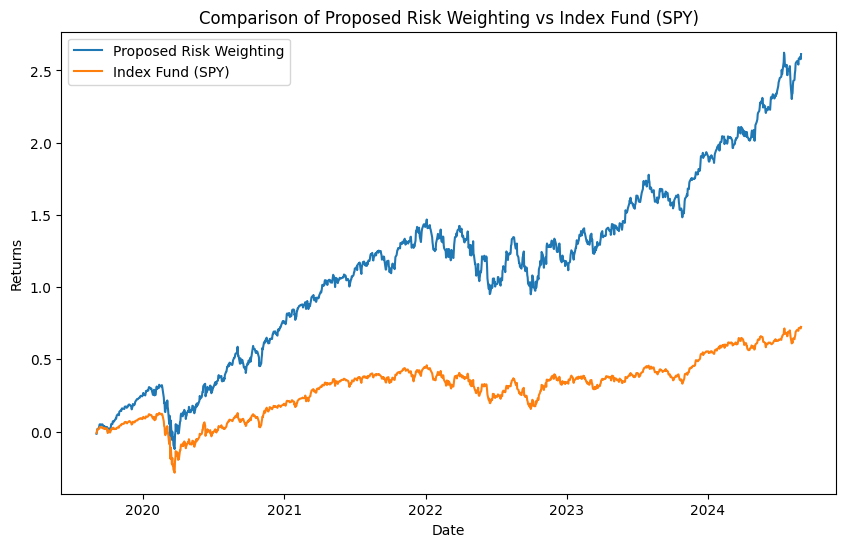

In [37]:
## Calculate the risk and return, then annualize it

# Calculate the minimum portfolio variance (risk)
max_return_portfolio_variance = np.sqrt(portfolio_variance(weights, cov_matrix))

# Calculate the expected return of the portfolio
max_return_port_e_r = sum(weights * df_return['Return'])

print("Weights:", weights)
print("Max Return Portfolio Variance: ", f'{max_return_portfolio_variance:.4f}')
print('Portfolio Expected Return: ', f'{max_return_port_e_r:.4f}')

# Annualize the return
max_return_annualized_return = (1 + max_return_port_e_r) ** 252 - 1
print(f"Annualized Return: {max_return_annualized_return:.4f}")

# Annualize the risk (standard deviation)
max_return_annualized_risk = max_return_portfolio_variance * np.sqrt(252)
print(f"Annualized Risk: {max_return_annualized_risk:.4f}")

#print sharpe return
print(f"Sharpe Ratio:{sharpe_r(weights, max_return_port_e_r, daily_rf_rate):.3f}")


## Create a column with the new weight

# Copy the df_return dataframe
df_temp = df_return.copy()

# Add the 'Min_risk_weights' column to df_temp with the calculated weights
df_temp['Max_return_weights'] = weights

# Round the 'Min_risk_weights' column to 3 decimal places
df_temp['Max_return_weights'] = df_temp['Max_return_weights'].round(decimals=3)

# Filter the dataframe to include only rows where 'Min_risk_weights' is not zero
# Reset the index and make a copy of the filtered dataframe
df_max_return_weight = df_temp[df_temp['Max_return_weights'] != 0].reset_index().copy()

# Set the 'Tickers' column as the index of the dataframe
df_max_return_weight.set_index('Tickers', inplace=True)

# Display the dataframe
print(df_max_return_weight)

##graphing portion
# Create a DataFrame for the cumulative returns of the proposed risk weighting
df_plot = pd.DataFrame(
    (1 + df_SP500_returns[df_max_return_weight.index.to_list()]  # Select returns for the dates in df_min_risk_weight
     .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later
     .pct_change()  # Calculate daily percentage change
     .dot(df_max_return_weight.iloc[:, 2].values)  # Dot product with the risk weights
    ).cumprod() - 1  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Rename the columns to 'Returns' and set the index name to 'Date'
df_plot.columns = ['Returns']
df_plot.index.name = 'Date'

# Convert the index to datetime format
df_plot.index = pd.to_datetime(df_plot.index)

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)
)

# Plot both dataframes on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['Returns'], label='Proposed Risk Weighting')
plt.plot(df_index_fund.index, df_index_fund.iloc[:, 0], label='Index Fund (SPY)')

# Adding title and labels
plt.title('Comparison of Proposed Risk Weighting vs Index Fund (SPY)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()

This portion is to optimize the Sharpe ratio which is the return /risk ratio

In [38]:
# Initial guess for the weights (random weights that sum to 1)
np.random.seed(42)
initial_weights = np.array([1.00 / len(df_cov)] * len(df_cov))
# Define the negative Sharpe ratio to use with minimize
def neg_sharpe_r(weights, expected_returns, daily_rf_rate):
    return -sharpe_r(weights, expected_returns, daily_rf_rate)

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights must be between 0 and 1
bounds = [(0, 1) for _ in range(len(initial_weights))]

# Assuming df_return contains the expected returns
expected_returns = df_return['Return'].values

# Minimize the negative Sharpe ratio to maximize the Sharpe ratio
result = minimize(neg_sharpe_r, initial_weights, args=(expected_returns, daily_rf_rate), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
weights = result.x

Weights: [8.33319603e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.33680869e-18 1.66680397e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.87348877e-17
 2.90566182e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.68375339e-17 0.00000000e+00 0.00000000e+00
 6.07153217e-18 3.49113100e-17 6.00648004e-17 0.00000000e+00
 0.00000000e+00 1.08420217e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.15573434e-17]
Max Sharpe Portfolio Variance:  0.0181
Portfolio Expected Return:  0.0012
Annualized Return: 0.3407
Annualized Risk: 0.2393
Sharpe Ratio:0.028
           Return      Risk  Min_risk_weights
Tickers                                      
AAPL     0.001206  0.019944             0.833
CAT      0.000953  0.020350             0.167


C:\Users\david\AppData\Local\Temp\ipykernel_15624\647342714.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later


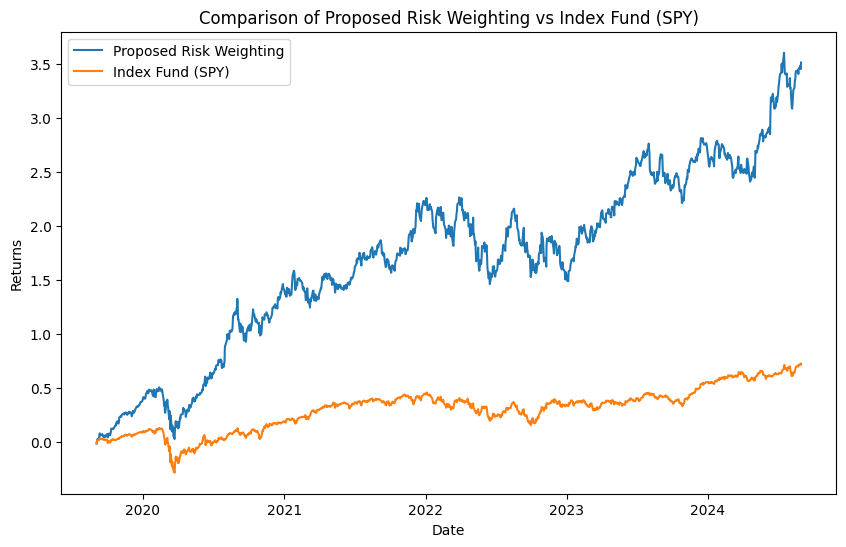

In [39]:
## Calculate the risk and return, then annualize it

# Calculate the minimum portfolio variance (risk)
max_sharpe_portfolio_variance = np.sqrt(portfolio_variance(weights, cov_matrix))

# Calculate the expected return of the portfolio
max_sharpe_port_e_r = sum(weights * df_return['Return'])

print("Weights:", weights)
print("Max Sharpe Portfolio Variance: ", f'{max_sharpe_portfolio_variance:.4f}')
print('Portfolio Expected Return: ', f'{max_sharpe_port_e_r:.4f}')

# Annualize the return
max_sharpe_annualized_return = (1 + max_sharpe_port_e_r) ** 252 - 1
print(f"Annualized Return: {max_sharpe_annualized_return:.4f}")

# Annualize the risk (standard deviation)
max_sharpe_annualized_risk = max_return_portfolio_variance * np.sqrt(252)
print(f"Annualized Risk: {max_sharpe_annualized_risk:.4f}")

#print sharpe return
print(f"Sharpe Ratio:{sharpe_r(weights, max_sharpe_port_e_r, daily_rf_rate):.3f}")


## Create a column with the new weight

# Copy the df_return dataframe
df_temp = df_return.copy()

# Add the 'Min_risk_weights' column to df_temp with the calculated weights
df_temp['Min_risk_weights'] = weights

# Round the 'Min_risk_weights' column to 3 decimal places
df_temp['Min_risk_weights'] = df_temp['Min_risk_weights'].round(decimals=3)

# Filter the dataframe to include only rows where 'Min_risk_weights' is not zero
# Reset the index and make a copy of the filtered dataframe
df_max_sharpe_weight = df_temp[df_temp['Min_risk_weights'] != 0].reset_index().copy()

# Set the 'Tickers' column as the index of the dataframe
df_max_sharpe_weight.set_index('Tickers', inplace=True)

# Display the dataframe
print(df_max_sharpe_weight)

##graphing portion
# Create a DataFrame for the cumulative returns of the proposed risk weighting
df_plot = pd.DataFrame(
    (1 + df_SP500_returns[df_max_sharpe_weight.index.to_list()]  # Select returns for the dates in df_min_risk_weight
     .fillna(method='bfill')  # Backfill NaNs for stocks that IPO later
     .pct_change()  # Calculate daily percentage change
     .dot(df_max_sharpe_weight.iloc[:, 2].values)  # Dot product with the risk weights
    ).cumprod() - 1  # Calculate cumulative product and subtract 1 to get cumulative returns
)

# Rename the columns to 'Returns' and set the index name to 'Date'
df_plot.columns = ['Returns']
df_plot.index.name = 'Date'

# Convert the index to datetime format
df_plot.index = pd.to_datetime(df_plot.index)

# Create a DataFrame to track cumulative returns of the index fund
df_index_fund = pd.DataFrame(
    ((1 + index_fund).cumprod() - 1)
)

# Plot both dataframes on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['Returns'], label='Proposed Risk Weighting')
plt.plot(df_index_fund.index, df_index_fund.iloc[:, 0], label='Index Fund (SPY)')

# Adding title and labels
plt.title('Comparison of Proposed Risk Weighting vs Index Fund (SPY)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
